In [212]:
# Importing the neccessary libraries for implementation
# pickle is imported for saving and loading the saved model.
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [213]:
# Creating the parent class named Layer.
class Layer:
  def __init__(self):

    # Initializing input and output as None
    self.input, self.output = None, None

  # Defining the forward pass of the Layer class for polymorizing the function in future use.
  def forward(self, input):
    raise NotImplementedError
    
  # Defining the backward pass of the Layer class for polymorizing the function in future use.
  def backward(self, gradient_output, learning_rate):
    raise NotImplementedError

In [214]:
# Defining Linear class inherited from the Layer class with forward an backward pases
class Linear(Layer):
  def __init__(self,  input_size, output_size):
    super().__init__()

    # Initializing a random seed for weights and bias
    np.random.seed(9)
    
    # Initializing the weights according to the size of input size and output size.
    self.weights = np.random.randn(input_size, output_size)

    # Initializing the bias according to the size of 1, output size.
    self.bias = np.random.randn(1, output_size)

  # Forward Propagation
  def forward(self, input):
    self.input = input
    self.output = np.dot(self.input, self.weights) + self.bias
    return self.output

  # Backward Propagation
  def backward(self, grad_out, learning_rate):

    # Finding local and weights gradients.
    local_grad = grad_out @ self.weights.T
    weights_grad = self.input.T @ grad_out

    # Updating the weights.
    self.weights -= learning_rate * weights_grad
    self.bias -= learning_rate * grad_out
    return local_grad

# Defining the Sigmoid Layer which is inherited from the Layer class.
class Sigmoid(Layer):
  def __init__(self):
    super().__init__()

  # Function for finding the sigmoid of x.
  def sigmoid(self, x):
    return 1 / (1 + np.exp(-x))

  # forward propagation
  def forward(self, input):
    self.input = input
    self.output = self.sigmoid(input)
    return self.output

  # Backward propagation
  def backward(self, grad_out, learning_rate):
    local_grad = self.output * (1 - self.output)
    return grad_out * local_grad

# Defining the Tanh Layer that is inherited fromt the Layer class.
class Tanh(Layer):
  def __init__(self):
    super().__init__()

  # Forward Propagation
  def forward(self, input):
    self.input, self.output = input, np.tanh(input)
    return self.output
  
  # Backward Propagation
  def backward(self, grad_out, learning_rate):
    local_grad = 1 - np.square(self.output)
    return grad_out * local_grad

# Defining the Softmax Layer that is inherited from the Layer class.
class Softmax(Layer):
  def __init__(self):
    super().__init__()

  # Forward Propagation
  def forward(self, input):
    self.input = input
    self.output = np.exp(input) / np.sum(np.exp(input))
    return self.output

  # Backward Propagation
  def backward(self, grad_out, learning_rate):
    return grad_out

# Defining the Cross entropy class that is inherited from the Layer class.
class CrossEntropy(Layer):
  def __init__(self):
    super().__init__()

  # Function for Cross Entropy
  def cross_entropy(self, pred_y, actual_y):
    return -np.sum(actual_y * np.log(pred_y))

  # Forward Propagation
  def forward(self, input, y_true):
    self.input, self.y_true = input, y_true 

    # Clipping the values between the range of [0, 1]
    input = np.clip(input, 1e-15, 1 - 1e-15)
    self.output = self.cross_entropy(input, y_true)
    return self.output

  # Backward Propagation
  def backward(self, grad_out, learning_rate):
    # num_samples = self.y_true.shape[0] 
    return grad_out * (self.input - self.y_true)


In [215]:
# # Implementing the Sequential Class that is inherited from the Layer class which helps in adding up the network of neural network.
# Implementing the Sequential Class that is inherited from the Layer class which helps in adding up the network of neural network.
class Sequential(Layer):
    def __init__(self):
        self.layers, self.Train_error, self.val_error, self.loss = [], [], [], None
    
    # Function to add layers to the network to make the Neural Network.
    def add(self, layer):
        self.layers.append(layer)

    # Fit Function to triain the Neural Network.
    def fit(self, X, y, epochs, learning_rate, patience, loss):

        # Initialize the loss class object.
        self.loss = loss

        # Finding the split value inorder to fit the data into 90 % Training and 10 % validation.
        split = int(0.9 * X.shape[0])
        X_train, y_train, X_Val, Y_Val = X[:split], y[:split], X[split:], y[split:]

        # Initializing the best loss and progress which is being compared with the patience.
        b_l, progress = float("inf"), 0

        # Training the Neural Network through each epochs
        for epoch in range(epochs):
            
            # Initializing the error and validation error as zero
            error, val_error = 0, 0

            # Passing through each samples of the training data.
            for i in range(len(X_train)):

                out = X_train[i]
                
                # Forward Propagation
                # Iterating through the different layers of the Network.
                for layer in self.layers:

                    out = layer.forward(out)

                # Finding the error
                error += self.loss.forward(out, y_train[i])

                # Backward Propagation Starts
                # Finding the Error gradients.
                grad_error = self.loss.backward(1, learning_rate)

                # Iterating through different layers of the Network.
                for layer in reversed(self.layers):
                    
                    # finding the error gradients during backpropagation.
                    grad_error = layer.backward(grad_error, learning_rate)

            # Finding y_pred using the X_val after all the samples have been trained.
            y_pred = self.predict(X_Val)
            
            # Handling dimensionality problem for different types of data.
            if y.shape[1] > 1:
                val_error += self.loss.forward(y_pred,np.argmax(Y_Val, axis = 1))
                val_error = val_error/y_pred.shape[0]
            else :
                val_error += self.loss.forward(y_pred, Y_Val)
                val_error = val_error/y_pred.shape[0]

            # Early stopping criterion to stop early when the progress becomes equal to patience.
            if val_error <= b_l: b_l, progress = val_error, 0
            else: progress +=1
            if progress == patience: break

            # Find the sampled errors.
            error /= len(X_train)

            # Appending the validation errors to the self.val_error for plotting the loss graph.
            self.val_error.append(val_error)

            # Appending the Training errors to the self.train_error for plotting the loss graph.
            self.Train_error.append(error)

            # Printing the Validation and Training Error per Epoch.
            print(f"Epoch {epoch+1} : Validation Error = {val_error}, Training Error = {error}")

    def predict(self, input_data):
            # Initializing the result and y_pred and empty list.
            result, y_pred = [], []

            # Iterating through all testing samples.
            for i in range(len(input_data)):

                # Taking the first input data.
                output = input_data[i]

                # Iterating through the layers.
                for layer in self.layers:
                    
                    # Finding the output of from the each layer.
                    output = layer.forward(output)
                
                # Appending the results to the results list.
                result.append(output)

            # Checking whether it is a binary classification problems and it returns 0 and 1 respectively.
            if len(result[0][0]) == 1: y_pred = [1 if abs(i[0][0]) >= 0.5 else 0 for i in result]

            # y_pred for multi classification.
            else: y_pred = [np.argmax(i[0], axis=0) for i in result]
            
            # Returinng the results as an array.
            return np.array(y_pred)
    
    # Function to determine the Accuracy of the Model.
    def Accuracy(self, y_pred, y_test):

      # Initializing the count for finding the match.
      count, n = 0, len(y_pred)
      for idx, ele in enumerate(y_pred):
          if ele == y_test[idx]: count += 1
      return (count/n)*100
    
    # Function for plotting the validation and Training Errors.
    def plotting(self, lr, Error):
      # Defining the plot size
      plt.figure(figsize=(10,8))

      # Making the plotting function plot for Training and Validation data separately.
      if Error == 'Training':
        plt.plot(self.Train_error, label ='Training Loss', color = "green")
      else:
        plt.plot(self.val_error, label ='Validation Loss', color = "darkorange")
      
      # Initializing title, xlabel, ylabel etc.
      plt.title(f"Loss vs Epochs when Learning Rate = {lr}", fontsize=15)
      plt.xlabel("No of Epochs",fontsize=15)
      plt.ylabel("loss per iteration", fontsize=15)
      plt.legend()
      plt.show()

In [216]:
# Initializing the Training and Testing data for XOR Operation.
X_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]],[[0,0]], [[0,1]], [[1,0]], [[1,1]],[[0,0]], [[0,1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]],[[0]], [[1]], [[1]], [[0]],[[0]], [[1]]])
X_test = np.array([[[1,1]], [[0,0]], [[1,1]], [[1,0]], [[0,0]]])
y_test = np.array([[[0]], [[0]], [[0]], [[1]], [[0]]])

## Training the XOR data using one hidden layer in sequential class and Hyperbolic Tangent Activation:

Epoch 1 : Validation Error = 9.992007221626415e-16, Training Error = 15.350567286626971
Epoch 2 : Validation Error = 9.992007221626415e-16, Training Error = 15.350567286626971
Epoch 3 : Validation Error = 9.992007221626415e-16, Training Error = 15.350567286626971
Epoch 4 : Validation Error = 9.992007221626415e-16, Training Error = 15.350567286626971
Epoch 5 : Validation Error = 9.992007221626415e-16, Training Error = 15.350567286626971
Epoch 6 : Validation Error = 9.992007221626415e-16, Training Error = 15.350567286626971
Epoch 7 : Validation Error = 9.992007221626415e-16, Training Error = 15.350567286626971
Epoch 8 : Validation Error = 9.992007221626415e-16, Training Error = 15.350567286626971
Epoch 9 : Validation Error = 9.992007221626415e-16, Training Error = 15.350567286626971
Epoch 10 : Validation Error = 9.992007221626415e-16, Training Error = 15.350567286626971
Epoch 11 : Validation Error = 9.992007221626415e-16, Training Error = 15.350567286626971
Epoch 12 : Validation Error = 

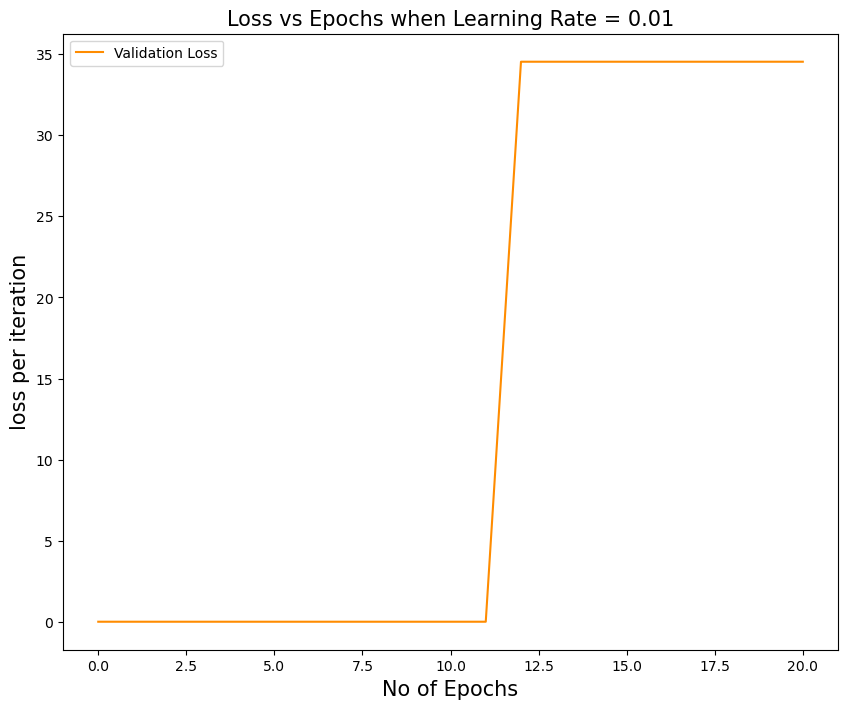

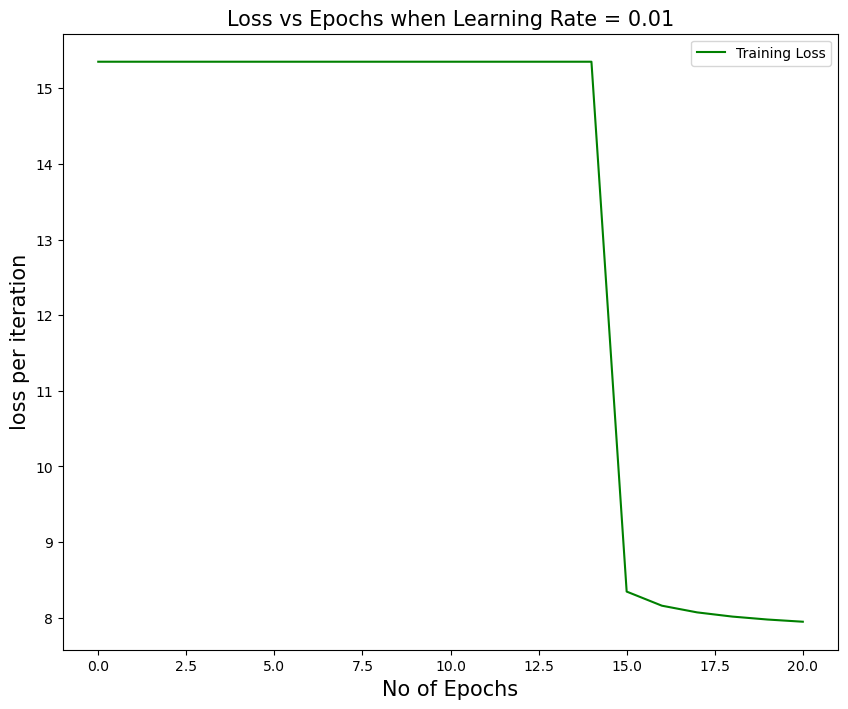

In [217]:
Neural_Network = Sequential()
Neural_Network.add(Linear(2, 1))
Neural_Network.add(Tanh())

learning_rate = 0.01
Neural_Network.fit(X_train, y_train, epochs=1000, learning_rate = learning_rate, patience = 10, loss = CrossEntropy())
y_pred = Neural_Network.predict(X_test)
print("Prediction: ",y_pred)
print("Accuracy of Model 1 =", Neural_Network.Accuracy(y_pred, y_test),"%")

Neural_Network.plotting(learning_rate, 'val')
Neural_Network.plotting(learning_rate, 'Training')

## Saving and Loading the Saved Model for XOR using Tanh()

In [218]:
# Saving the model
with open('XOR_model1.pkl', 'wb') as output:
    pickle.dump(Neural_Network, output, pickle.HIGHEST_PROTOCOL)

In [219]:
# Loading the saved model
with open('XOR_model1.pkl', 'rb') as inp:
    XOR_model1 = pickle.load(inp)

In [220]:
# test the model
y_pred = XOR_model1.predict(X_test)
print("Accuracy of Model 1 = ", XOR_model1.Accuracy(y_pred, y_test),"%")

Accuracy of Model 1 =  80.0 %


## Training the XOR data using one hidden layer in sequential class and SIgmoid() Activation.

Epoch 1 : Validation Error = 34.538776394910684, Training Error = 0.6713306649478356
Epoch 2 : Validation Error = 34.538776394910684, Training Error = 0.6694751769307139
Epoch 3 : Validation Error = 34.538776394910684, Training Error = 0.6676236202041991
Epoch 4 : Validation Error = 34.538776394910684, Training Error = 0.6657760675289104
Epoch 5 : Validation Error = 34.538776394910684, Training Error = 0.663932591380058
Epoch 6 : Validation Error = 34.538776394910684, Training Error = 0.6620932639268925
Epoch 7 : Validation Error = 34.538776394910684, Training Error = 0.660258157012171
Epoch 8 : Validation Error = 34.538776394910684, Training Error = 0.6584273421316502
Epoch 9 : Validation Error = 34.538776394910684, Training Error = 0.6566008904136257
Epoch 10 : Validation Error = 34.538776394910684, Training Error = 0.6547788725985284
Epoch 11 : Validation Error = 34.538776394910684, Training Error = 0.6529613590185945
Epoch 12 : Validation Error = 34.538776394910684, Training Error 

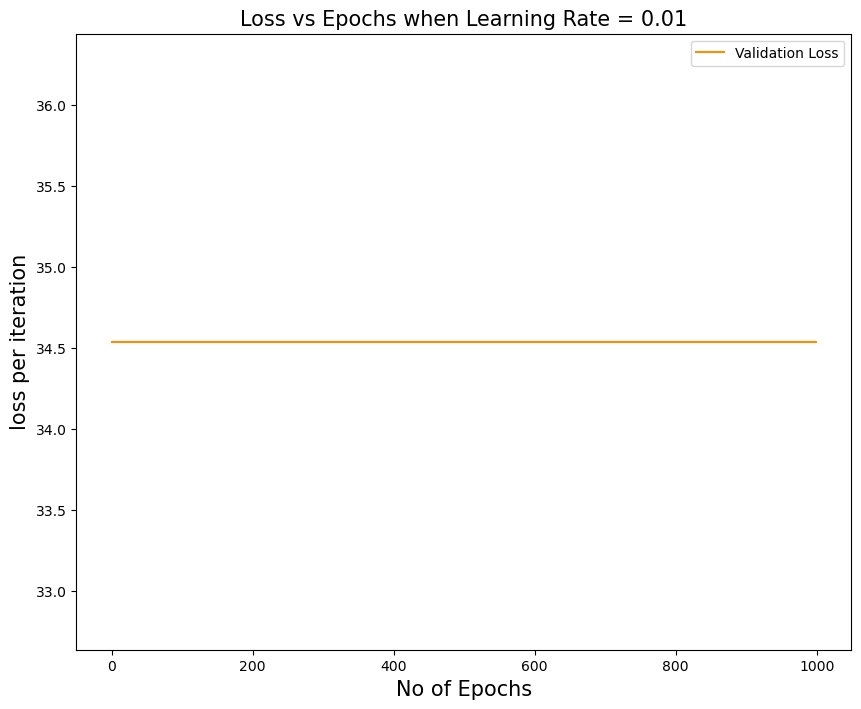

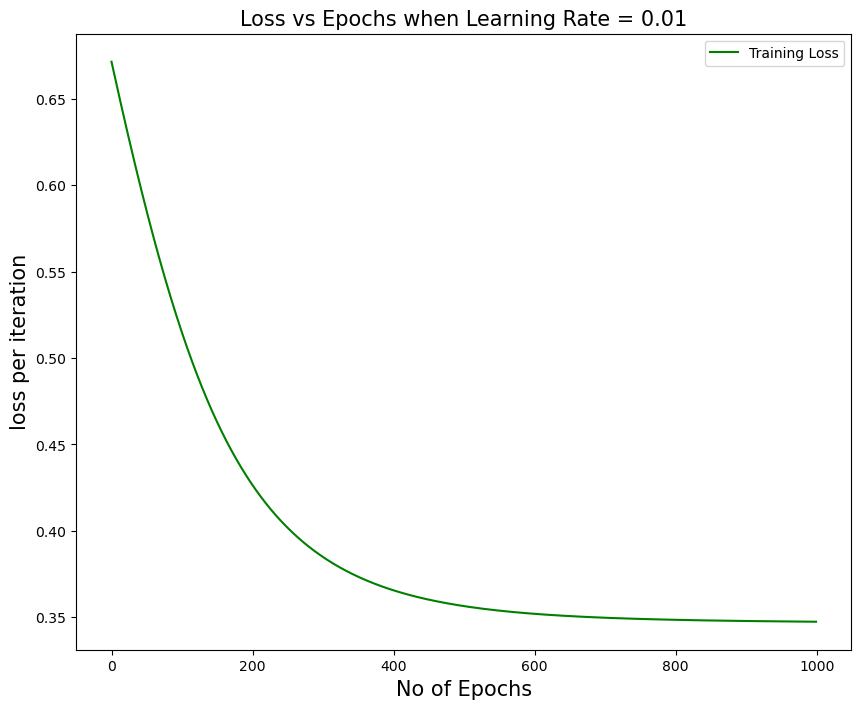

In [221]:
Neural_Network = Sequential()
Neural_Network.add(Linear(2, 1))
Neural_Network.add(Sigmoid())

learning_rate = 0.01
Neural_Network.fit(X_train, y_train, epochs=1000, learning_rate=learning_rate, patience=10, loss = CrossEntropy())
y_pred = Neural_Network.predict(X_test)
print("Prediction: ",y_pred)
print("Accuracy of Model 2 = ", Neural_Network.Accuracy(y_pred, y_test),"%")

Neural_Network.plotting(learning_rate, 'val')
Neural_Network.plotting(learning_rate, 'Training')

## Saving and loading the saved model for XOR

In [222]:
# Saving the model
with open('XOR_model2.pkl', 'wb') as output:
    pickle.dump(Neural_Network, output, pickle.HIGHEST_PROTOCOL)

In [223]:
# Loading the saved model
with open('XOR_model2.pkl', 'rb') as inp:
    XOR_model2 = pickle.load(inp)

In [224]:
# test the model
y_pred = XOR_model2.predict(X_test)
print("Accuracy of model 2 = ", XOR_model2.Accuracy(y_pred, y_test),"%")

Accuracy of model 2 =  40.0 %


## Sequential Model with Tanh() Activation performed a better result when compared with sigmoid.

# Part 2. Training Network using the Sequential class on MNIST Dataset

In [225]:
# Loading MNIST Dataset from keras.datasets
from keras.datasets import mnist

In [226]:
# Splitting the data into X_train, y_train, X_test, y_test
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [227]:
# Function to one hot encode the data since the y_train contains strings representing from '0' to '9'.
def One_hot_encode(targets, classes):

  # Creates an identity matrix with the shape of classes by classes.
  result = np.eye(classes)[np.array(targets).reshape(-1)]

  # Reshaping it to proper format.
  return result.reshape(list(targets.shape)+[classes])

In [228]:
# Reshaping the Training data
X_train = X_train.reshape(X_train.shape[0], 1, 28*28)
X_train = X_train.astype('float32')

# Normalizing the Training data
X_train /= 255

# Encoding y_train.
y_train =  One_hot_encode(y_train.astype(int), 10)

In [229]:
# Reshaping the Testing data
X_test = X_test.reshape(X_test.shape[0], 1, 28*28)
X_test = X_test.astype('float32')

# Normalizing the Testing data
X_test /= 255

# Encoding y_test
y_test =  np.argmax(One_hot_encode(y_test.astype(int), 10),axis = 1)

## Model 1

Epoch 1 : Validation Error = 4.196461331981651, Training Error = 1.8656758252274372
Epoch 2 : Validation Error = 3.3445048475738557, Training Error = 0.9461262284148576
Epoch 3 : Validation Error = 2.7515891861278887, Training Error = 0.7583694505690914
Epoch 4 : Validation Error = 2.175942912879377, Training Error = 0.6608673704779389
Epoch 5 : Validation Error = 1.8708503880576661, Training Error = 0.597058404515482
Epoch 6 : Validation Error = 1.8247986861977854, Training Error = 0.5512619645275694
Epoch 7 : Validation Error = 1.79601637253536, Training Error = 0.515786762980795
Epoch 8 : Validation Error = 1.5887837141658958, Training Error = 0.4866785242731349
Epoch 9 : Validation Error = 1.5254626241085596, Training Error = 0.4620236595308412
Epoch 10 : Validation Error = 1.5254626241085596, Training Error = 0.4408483242985982
Prediction:  [7 6 1 ... 4 5 6]
Accuracy of Model 1 = 85.24000000000001 %


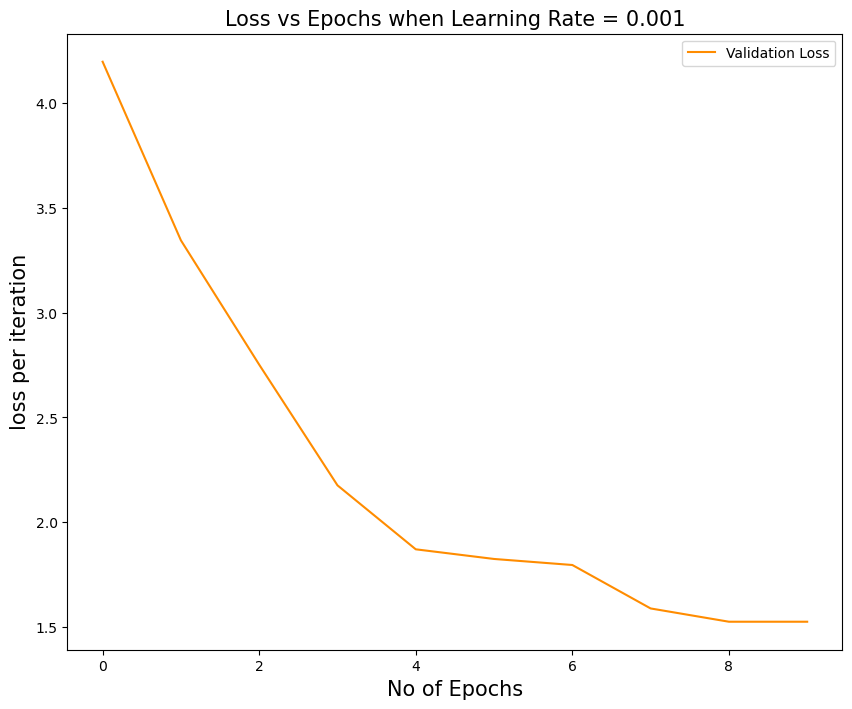

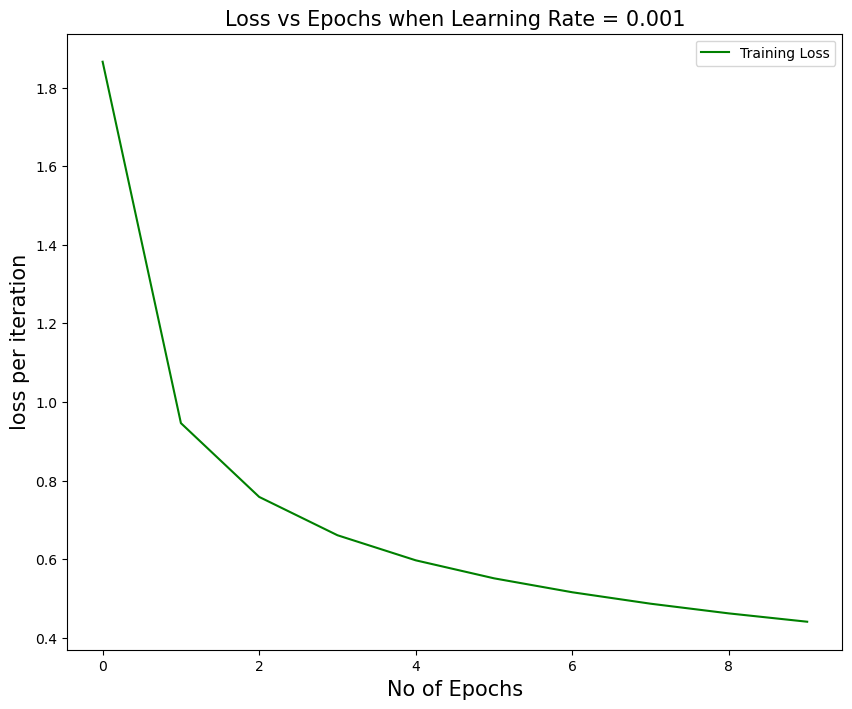

In [230]:
Neural_Network = Sequential()
Neural_Network.add(Linear(784, 100))     
Neural_Network.add(Tanh())
Neural_Network.add(Linear(100, 50)) 
Neural_Network.add(Sigmoid())
Neural_Network.add(Linear(50, 10))
Neural_Network.add(Softmax())
lr = 0.001
Neural_Network.fit(X_train, y_train, epochs=10, learning_rate=lr, patience=5, loss = CrossEntropy())
y_pred = Neural_Network.predict(X_test)
print("Prediction: ",y_pred)
print("Accuracy of Model 1 =", Neural_Network.Accuracy(y_pred, y_test),"%")

Neural_Network.plotting(lr, 'val')
Neural_Network.plotting(lr, 'Training')


In [231]:
# Saving the model
with open('Model1.pkl', 'wb') as output:
    pickle.dump(Neural_Network, output, pickle.HIGHEST_PROTOCOL)

In [232]:
# Loading the saved model
with open('Model1.pkl', 'rb') as inp:
    model1 = pickle.load(inp)

In [233]:
# test the model
y_pred = model1.predict(X_test)
print("Accuracy of MNIST Model 1 =", model1.Accuracy(y_pred, y_test),"%")

Accuracy of MNIST Model 1 = 85.24000000000001 %


## Model 2

Epoch 1 : Validation Error = 0.840443558942831, Training Error = 0.6989739875808714
Epoch 2 : Validation Error = 0.6216979751083966, Training Error = 0.34108681980793215
Epoch 3 : Validation Error = 0.47202994406378374, Training Error = 0.27560156657676527
Epoch 4 : Validation Error = 0.3914394658089923, Training Error = 0.23751127820877072
Epoch 5 : Validation Error = 0.3569006894140815, Training Error = 0.21073706288868044
Epoch 6 : Validation Error = 0.2878231366242602, Training Error = 0.19015299436743732
Epoch 7 : Validation Error = 0.29933606208923036, Training Error = 0.1735525308512477
Epoch 8 : Validation Error = 0.29933606208923036, Training Error = 0.1597364275743544
Epoch 9 : Validation Error = 0.29933606208923036, Training Error = 0.14799852408054
Epoch 10 : Validation Error = 0.2532843602293495, Training Error = 0.1378828538268598
Epoch 11 : Validation Error = 0.2647972856943197, Training Error = 0.12907997192387316
Epoch 12 : Validation Error = 0.2647972856943197, Traini

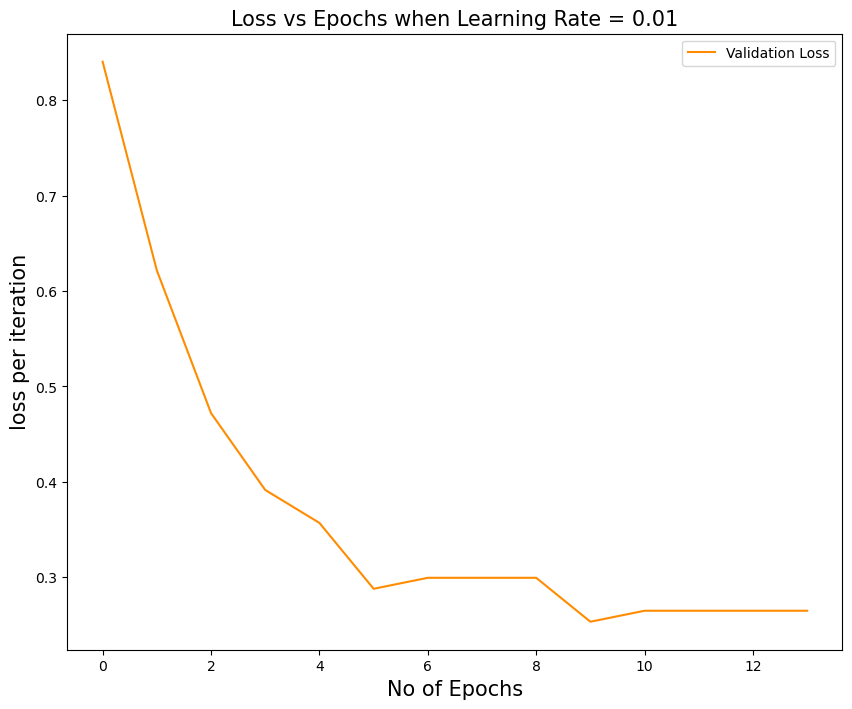

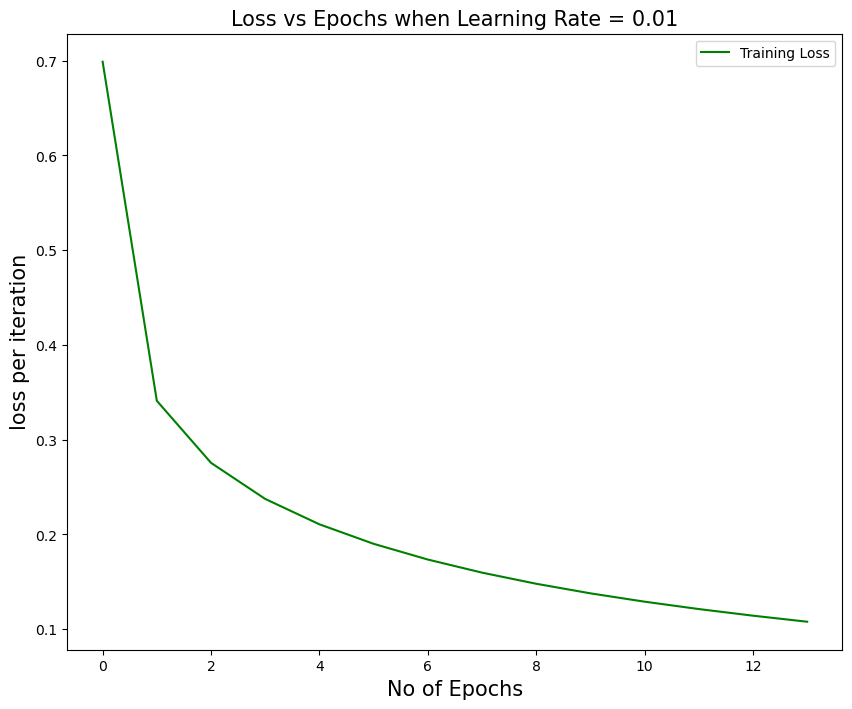

In [234]:
Neural_Network = Sequential()
Neural_Network.add(Linear(784, 100))     
Neural_Network.add(Sigmoid())
Neural_Network.add(Linear(100, 10)) 
Neural_Network.add(Softmax())

lr = 0.01
Neural_Network.fit(X_train, y_train, epochs=15, learning_rate=lr, patience=5, loss = CrossEntropy())
y_pred = Neural_Network.predict(X_test)
print("Prediction: ",y_pred)
print("Accuracy of Model 2 =", Neural_Network.Accuracy(y_pred, y_test),"%")

Neural_Network.plotting(learning_rate, 'val')
Neural_Network.plotting(learning_rate, 'Training')

In [235]:
# Saving the model
with open('Model2.pkl', 'wb') as output:
    pickle.dump(Neural_Network, output, pickle.HIGHEST_PROTOCOL)

In [236]:
# Loading the saved model
with open('Model2.pkl', 'rb') as inp:
    model2 = pickle.load(inp)

In [237]:
# test the model
y_pred = model2.predict(X_test)
print("Accuracy of model 2 = ", model2.Accuracy(y_pred, y_test),"%")

Accuracy of model 2 =  94.69999999999999 %


## Model 3 for MNIST dataset

Epoch 1 : Validation Error = 0.3281183757516559, Training Error = 1.8666481574659948
Epoch 2 : Validation Error = 0.5008122577262093, Training Error = 0.84701590741006
Epoch 3 : Validation Error = 0.39719592854147734, Training Error = 0.6775536059047937
Epoch 4 : Validation Error = 0.04605170185988537, Training Error = 0.5882411515170973
Epoch 5 : Validation Error = 0.6101850496434265, Training Error = 0.5181459078802166
Epoch 6 : Validation Error = 0.01726938819745982, Training Error = 0.4580109075424428
Epoch 7 : Validation Error = 0.5468639595860901, Training Error = 0.42100310311559047
Epoch 8 : Validation Error = 1.2779347266116996, Training Error = 0.4059949340850151
Prediction:  [7 2 1 ... 4 8 6]
Accuracy of Model 3 = 91.22 %


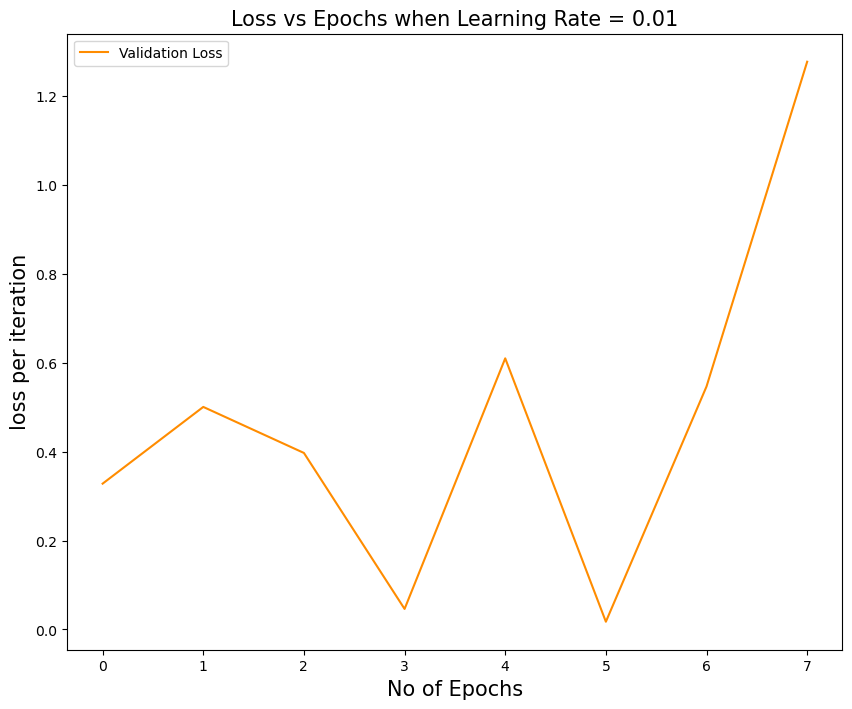

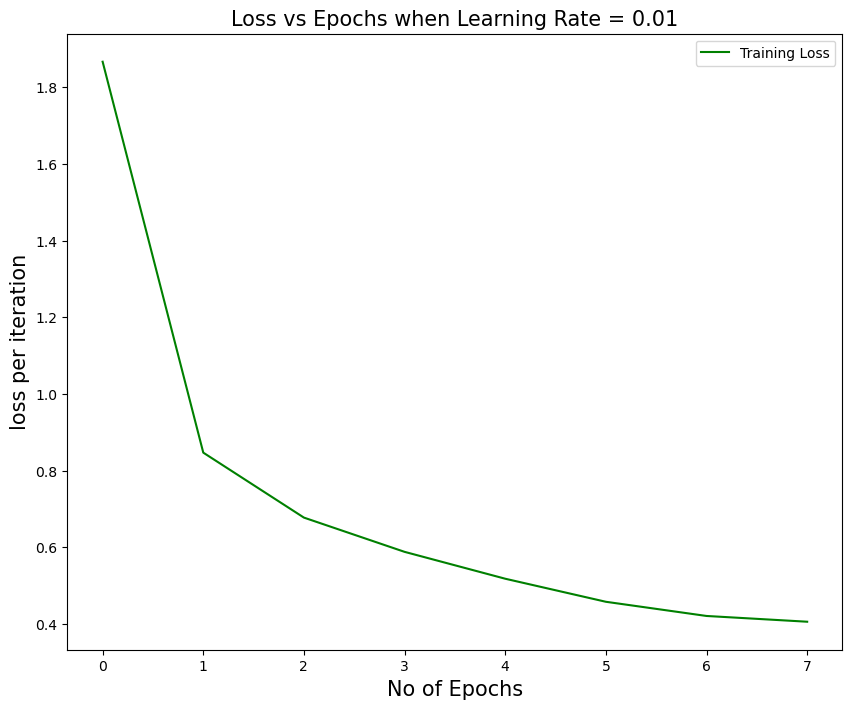

In [238]:
# Neural_Network
Neural_Network = Sequential()
Neural_Network.add(Linear(784, 500))     
Neural_Network.add(Tanh())
Neural_Network.add(Linear(500, 400 )) 
Neural_Network.add(Tanh())
Neural_Network.add(Linear(400, 10)) 
Neural_Network.add(Softmax())


Neural_Network.fit(X_train, y_train, epochs = 8, learning_rate = 0.01, patience=5, loss = CrossEntropy())
y_pred = Neural_Network.predict(X_test)
print("Prediction: ",y_pred)
print("Accuracy of Model 3 =", Neural_Network.Accuracy(y_pred, y_test),"%")

Neural_Network.plotting(learning_rate, 'val')
Neural_Network.plotting(learning_rate, 'Training')

In [239]:
# Saving the model
with open('Model3.pkl', 'wb') as output:
    pickle.dump(Neural_Network, output, pickle.HIGHEST_PROTOCOL)

In [240]:
# Loading the saved model
with open('Model3.pkl', 'rb') as inp:
    model3 = pickle.load(inp)

In [241]:
# test the model
y_pred = model3.predict(X_test)
print("Accuracy of Model 3 = ", model3.Accuracy(y_pred, y_test),"%")


Accuracy of Model 3 =  91.22 %


## Model 4 for MNIST Dataset

Epoch 1 : Validation Error = 3.747457238847813, Training Error = 2.5232026934641105
Epoch 2 : Validation Error = 2.8552055153126203, Training Error = 1.0829562772962293
Epoch 3 : Validation Error = 2.7170504097329777, Training Error = 0.839544795591853
Epoch 4 : Validation Error = 2.020518419102279, Training Error = 0.7116152018550341
Epoch 5 : Validation Error = 1.5139496986435892, Training Error = 0.6270746257954871
Prediction:  [7 0 1 ... 4 5 6]
Accuracy of Model 4 = 80.21000000000001 %


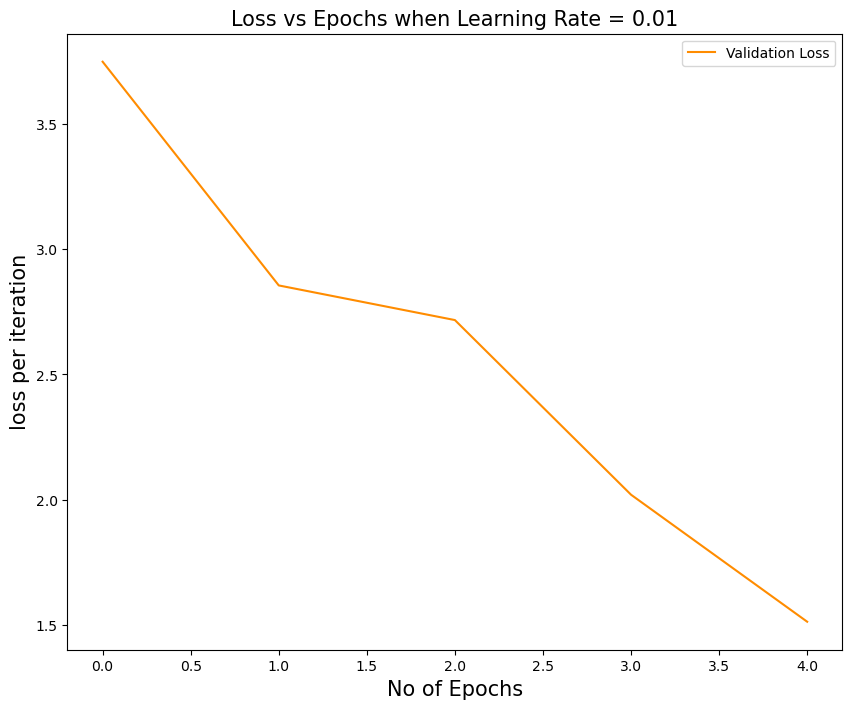

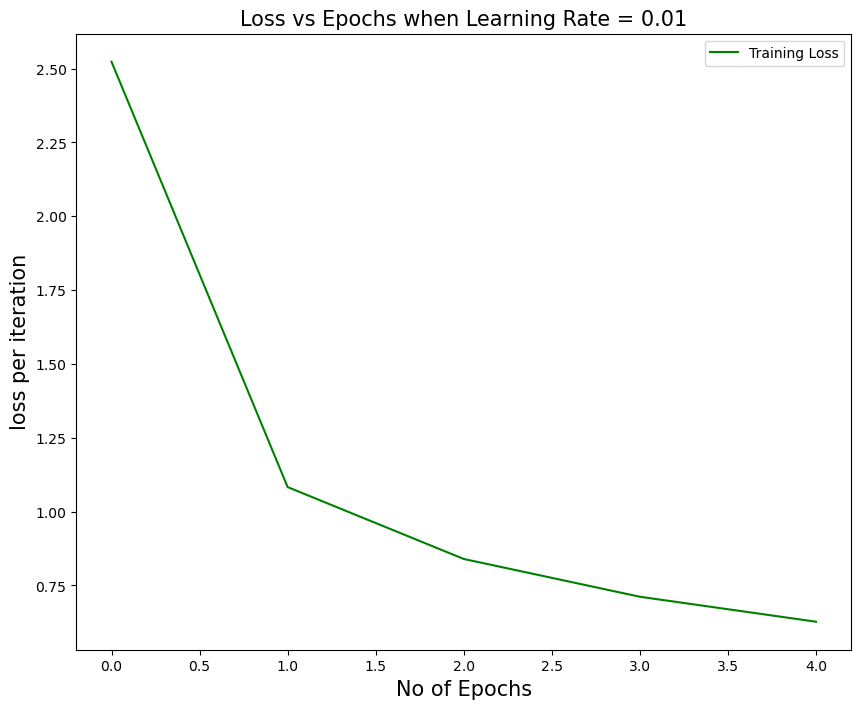

In [243]:
# Neural_Network
Neural_Network = Sequential()
Neural_Network.add(Linear(784, 360))     
Neural_Network.add(Tanh())
Neural_Network.add(Linear(360, 100 )) 
Neural_Network.add(Tanh())
Neural_Network.add(Linear(100, 50)) 
Neural_Network.add(Tanh())
Neural_Network.add(Linear(50, 10)) 
Neural_Network.add(Softmax())


Neural_Network.fit(X_train, y_train, epochs = 5, learning_rate = 0.001, patience=5, loss = CrossEntropy())
y_pred = Neural_Network.predict(X_test)
print("Prediction: ",y_pred)
print("Accuracy of Model 4 =", Neural_Network.Accuracy(y_pred, y_test),"%")

Neural_Network.plotting(learning_rate, 'val')
Neural_Network.plotting(learning_rate, 'Training')

In [244]:
# Saving the model
with open('Model4.pkl', 'wb') as output:
    pickle.dump(Neural_Network, output, pickle.HIGHEST_PROTOCOL)

In [245]:
# Loading the saved model
with open('Model4.pkl', 'rb') as inp:
    model4 = pickle.load(inp)

In [246]:
# test the model
y_pred = model4.predict(X_test)
print("Accuracy of Model 4 = ", model4.Accuracy(y_pred, y_test),"%")

Accuracy of Model 4 =  80.21000000000001 %


From the overall training done on three models the model 2 with sigmoid and a softmax layer performed better compared to the other two.
Model 3 was taking a huge amount of time to train as it was having 500 nodes in some layers but the accuracy didnot came to be as the 2nd model.
The 4th Model was also performing less than all other models.